In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import random
import keras
import h5py

In [4]:
# Import the labels
input_directory = "kaggle/input/histopathologic-cancer-detection/"
working_directory = "kaggle/working/"
tmp_directory = "kaggle/temp"
directory = input_directory + "train_labels.csv"
test_data_list = pd.read_csv(directory)
test_data_list.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Cancer Free
Channels: ('R', 'G', 'B')


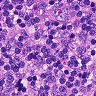

Cancerous
Channels: ('R', 'G', 'B')


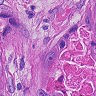

Cancerous
Channels: ('R', 'G', 'B')


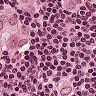

Cancer Free
Channels: ('R', 'G', 'B')


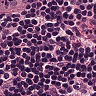

Cancerous
Channels: ('R', 'G', 'B')


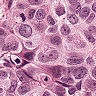

Cancer Free
Channels: ('R', 'G', 'B')


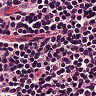

Cancerous
Channels: ('R', 'G', 'B')


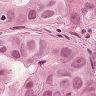

Cancer Free
Channels: ('R', 'G', 'B')


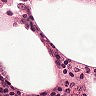

Cancer Free
Channels: ('R', 'G', 'B')


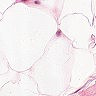

Cancerous
Channels: ('R', 'G', 'B')


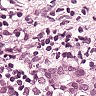

In [5]:
#print random images with lablels
samples = test_data_list.iloc[random.sample(range(0,test_data_list.shape[0]), 10)]
#print(samples)
for sample in samples.iterrows():
    #print(sample[1])
    path = input_directory + "train/" + str(sample[1]["id"]) + ".tif"
    if sample[1]["label"] == 0:
        print("Cancer Free")
    else:
        print("Cancerous")
    im = Image.open(path)
    print("Channels: " + str(im.getbands()))
    display(im)


- Cancerous vs Cancer Free numbers in train set
- Size of set
- Find more later

In [6]:
directory = input_directory + "train/"
print(directory)


kaggle/input/histopathologic-cancer-detection/train/


In [10]:
def load_and_prodess_image(filename):
    path=input_directory + "train/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255

test_data_list['image_data'] = test_data_list['id'].apply(load_and_prodess_image)


In [13]:
X = np.stack(test_data_list['image_data'].values)
y = test_data_list['label'].values
path = working_directory + 'image_data.h5'
hdf5_file = path

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=X)
    f.create_dataset('labels', data=y)

In [7]:
path = working_directory + 'image_data.h5'
hdf5_file = path
with h5py.File(hdf5_file, 'r') as f:
    # Load the datasets back into memory
    X = f['images'][:]
    y = f['labels'][:]

In [10]:
# Developed with help from https://keras.io/api/models/model/
inputs = keras.Input(shape=(32,32,3))
def activation_block(input, filters):
    filters = 32
    kernel_size=(3,3)
    conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (inputs)
    conv2 = conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (conv1)
    pool = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None
    )(conv2)
    dropout = keras.layers.Dropout(0.25)(pool)
    return dropout
    
activation1 = activation_block(inputs, 32)
activation2 = activation_block(activation1, 32)
activation3 = activation_block(activation2, 32)
#activation4 = activation_block(activation3, 32)
#activation5 = activation_block(activation4, 32)

flatten= keras.layers.Flatten()(activation2)
dense1 = keras.layers.Dense(1024, activation='relu') (flatten)
drop1 = keras.layers.Dropout(0.25)(dense1)
dense2 = keras.layers.Dense(1024, activation='relu') (drop1)
drop2 = keras.layers.Dropout(0.25)(dense2)
dense3 = keras.layers.Dense(256, activation='relu') (drop2)
drop3 = keras.layers.Dropout(0.25)(dense3)


outputs = keras.layers.Dense(1, activation="sigmoid")(drop3)

full_model = keras.Model(inputs, outputs)

# set up optomizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
full_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
full_model.fit(
    x=X,
    y=y,
    batch_size=64,
    epochs=10,
    verbose=2,
    callbacks=None,
    validation_split=0.2,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)


Epoch 1/10
2751/2751 - 248s - loss: 0.6465 - binary_accuracy: 0.6073 - val_loss: 0.6145 - val_binary_accuracy: 0.6440 - 248s/epoch - 90ms/step
Epoch 2/10
2751/2751 - 255s - loss: 0.5789 - binary_accuracy: 0.6945 - val_loss: 0.5294 - val_binary_accuracy: 0.7468 - 255s/epoch - 93ms/step
Epoch 3/10
